### Importar librerías:

In [71]:
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pandas as pd

### 1. Importar Lista de vehículos ligeros eléctricos con precios en Europa "WEB SCRAPING":

In [ ]:
# URL base de la página a hacer scraping
base_url = 'https://ev-database.org/'
url = base_url

# Lista para almacenar los datos
data = []

# Diccionario para almacenar los precios por vehículo y país
prices = {}

# Realizar solicitudes GET a cada página
while True:
    # Realizar la solicitud GET a la página
    response = requests.get(url)

    # Verificar si la solicitud fue exitosa (código de estado 200)
    if response.status_code == 200:
        # Parsear el contenido HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Encontrar todos los elementos <div> con la clase 'list-item'
        list_items = soup.find_all('div', class_='list-item')

        # Iterar sobre los elementos 'list-item' y extraer información
        for item in list_items:
            # Buscar el elemento <div> con la clase 'data-wrapper' dentro del elemento 'list-item'
            data_wrapper = item.find('div', class_='data-wrapper')
            if data_wrapper:
                # Buscar el elemento <a> con la clase 'title'
                title_link = data_wrapper.find('a', class_='title')
                if title_link:
                    # Obtener el nombre del vehículo
                    car_name = title_link.text.strip()

                    # Buscar el elemento <div> con la clase 'specs' para obtener información adicional
                    specs_div = item.find('div', class_='specs')
                    # Velocidad máxima
                    top_speed_tag = specs_div.find('span', class_='topspeed')
                    top_speed = top_speed_tag.text.strip() if top_speed_tag else "Velocidad máxima no encontrada"
                    # Tiempo de 0 a 100 km/h
                    acceleration_tag = specs_div.find('span', class_='acceleration')
                    acceleration = acceleration_tag.text.strip() if acceleration_tag else "Tiempo de 0 a 100 km/h no encontrado"
                    # Rango
                    range_tag = specs_div.find('span', class_='erange_real')
                    range_value = range_tag.text.strip() if range_tag else "Rango no encontrado"
                    # Carga rápida
                    fastcharge_speed_tag = specs_div.find('span', class_='fastcharge_speed_print')
                    fastcharge_speed = fastcharge_speed_tag.text.strip() if fastcharge_speed_tag else "Velocidad de carga rápida no encontrada"

                    # Encontrar todos los elementos <span> con la clase 'price_buy' dentro del elemento de precios
                    pricing_elements = item.find_all('span', class_='price_buy')
                    # Iterar sobre los elementos de precio
                    for pricing_element in pricing_elements:
                        # Extraer el texto dentro del elemento como el precio
                        price_text = pricing_element.text.strip()
                        # Extraer el país de la clase del elemento (por ejemplo, 'country_de', 'country_nl', etc.)
                        country_code = pricing_element.find('span', class_='flag-icon').attrs['class'][1].replace('country_', '').upper()
                        # Agregar el precio al diccionario de precios, utilizando el nombre del vehículo como clave
                        if car_name not in prices:
                            prices[car_name] = {}
                        prices[car_name][country_code] = price_text

                    # Agregar los datos a la lista
                    data.append({
                        "Nombre del vehículo": car_name,
                        "Velocidad máxima": top_speed,
                        "Tiempo de 0 a 100 km/h": acceleration,
                        "Rango": range_value,
                        "Velocidad de carga rápida": fastcharge_speed,
                        **prices[car_name]  # Agregar precios al diccionario de datos
                    })

        # Encontrar el enlace a la siguiente página, si existe
        next_page_link = soup.find('a', class_='next')
        if next_page_link:
            url = base_url + next_page_link['href']
        else:
            break  # Salir del bucle si no hay más páginas disponibles
    else:
        print('Error al acceder a la página:', response.status_code)
        break


### 2. Corregir formato de números y renombrar columnas:

In [60]:
# Crear un DataFrame de Pandas con los datos
df = pd.DataFrame(data)

# Renombrar las columnas
df.rename(columns={
    'Velocidad máxima': 'Velocidad Máxima (Km/h)',
    'Tiempo de 0 a 100 km/h': 'Aceleración 0 a 100 Km/h (seg)',
    'Rango': 'Rango (Km)',
    'Velocidad de carga rápida': 'Carga rápida (Km/h)'
}, inplace=True)

# Limpiar los datos numéricos
df['Velocidad Máxima (Km/h)'] = df['Velocidad Máxima (Km/h)'].str.extract('(\d+)').astype(float)
df['Aceleración 0 a 100 Km/h (seg)'] = df['Aceleración 0 a 100 Km/h (seg)'].str.extract('(\d+\.?\d*)').astype(float)
df['Rango (Km)'] = df['Rango (Km)'].str.extract('(\d+)').astype(float)
df['Carga rápida (Km/h)'] = df['Carga rápida (Km/h)'].str.extract('(\d+)').astype(float)

# Mostrar el DataFrame resultante
df.head()


,Nombre del vehículo,Velocidad Máxima (Km/h),Aceleración 0 a 100 Km/h (seg),Rango (Km),Carga rápida (Km/h),FLAG-ICON-DE,FLAG-ICON-NL,FLAG-ICON-GB
0,Tesla Model 3,201.0,6.1,415.0,690.0,"€43,970","€43,993","£39,990"
1,Tesla Model 3 Long Range Dual Motor,201.0,4.4,500.0,770.0,"€52,970","€51,993","£49,990"
2,BYD ATTO 3,160.0,7.3,330.0,370.0,"€37,990","€38,990","£37,195"
3,Tesla Model Y Long Range Dual Motor,217.0,5.0,435.0,670.0,"€53,470","€50,990","£52,990"
4,Tesla Model Y,217.0,6.9,350.0,580.0,"€45,970","€43,990","£44,990"


### 3. Renombrar columnas de precios y arreglar valores:

In [61]:
# Renombrar las columnas de precio
df.rename(columns={
    'FLAG-ICON-DE': 'Alemania (€)',
    'FLAG-ICON-NL': 'Holanda (€)',
    'FLAG-ICON-GB': 'Inglaterra (€)'
}, inplace=True)

# Limpiar los valores de las columnas de precio
for country in ['Alemania (€)', 'Holanda (€)', 'Inglaterra (€)']:
    df[country] = df[country].str.replace('*', '')  # Eliminar asteriscos
    df[country] = df[country].str.replace('[^\d,.]', '', regex=True)  # Eliminar caracteres no numéricos
    df[country] = df[country].str.replace(',', '', regex=False)  # Eliminar comas como separadores de miles
    df[country] = pd.to_numeric(df[country], errors='coerce')  # Convertir a tipo numérico


### 4. Unificar precios a promedio Europa en Euros:

In [64]:
# Crear la columna "Europa (€)" que promedia los valores de las tres columnas de precios, ignorando los valores nulos
df['Europa (€)'] = df[['Alemania (€)', 'Holanda (€)', 'Inglaterra (€)']].mean(axis=1, skipna=True)

# Eliminar las columnas individuales de precios
df.drop(columns=['Alemania (€)', 'Holanda (€)', 'Inglaterra (€)'], inplace=True)


### 5. Eliminar registros nulos y duplicados:

In [66]:
# Eliminar registros nulos
df.dropna(inplace=True)

# Eliminar registros duplicados
df.drop_duplicates(inplace=True)

De existir pero los datos vienen limpios.

In [68]:
# Guardar el DataFrame en un archivo CSV
#df.to_csv('../DataClean/datos_vehiculos.csv', index=False)

### 6. Vehículos más económicos y vhs más costosos:

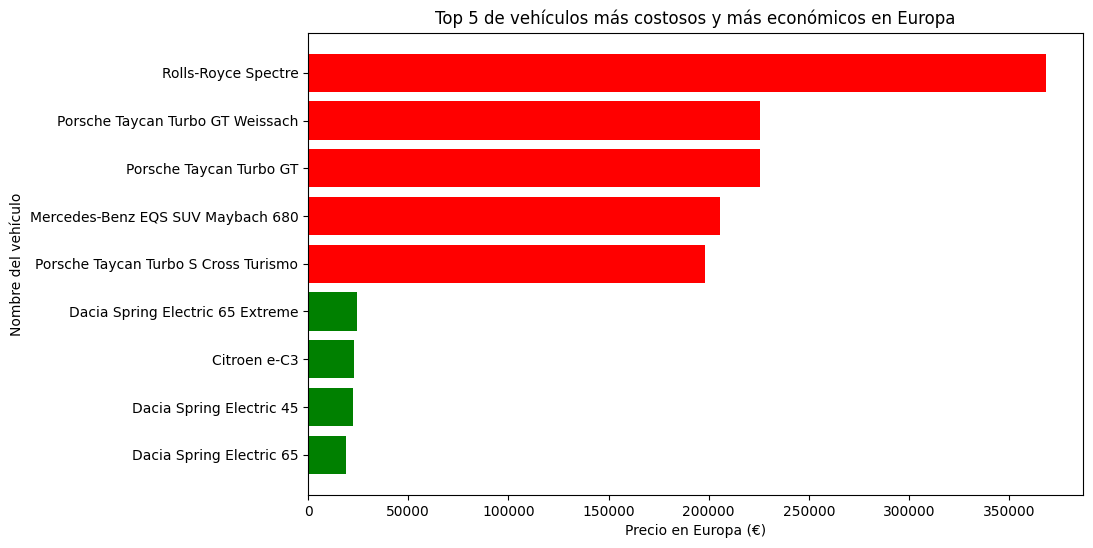

In [72]:
# Ordenar el DataFrame por la columna "Europa (€)"
df_sorted = df.sort_values(by='Europa (€)', ascending=False)

# Obtener los 5 vehículos más costosos y los 5 más económicos
top_5_expensive = df_sorted.head(5)
top_5_cheap = df_sorted.tail(5)

# Concatenar los DataFrames de los vehículos más costosos y más económicos
top_5 = pd.concat([top_5_expensive, top_5_cheap])

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(top_5['Nombre del vehículo'], top_5['Europa (€)'], color=['red' if p >= df_sorted.iloc[5]['Europa (€)'] else 'green' for p in top_5['Europa (€)']])
plt.xlabel('Precio en Europa (€)')
plt.ylabel('Nombre del vehículo')
plt.title('Top 5 de vehículos más costosos y más económicos en Europa')
plt.gca().invert_yaxis()  # Invertir el eje y para que el vehículo más caro esté en la parte superior
plt.show()


### 7. Top 5 de los vehículos pr cada variable de interés:

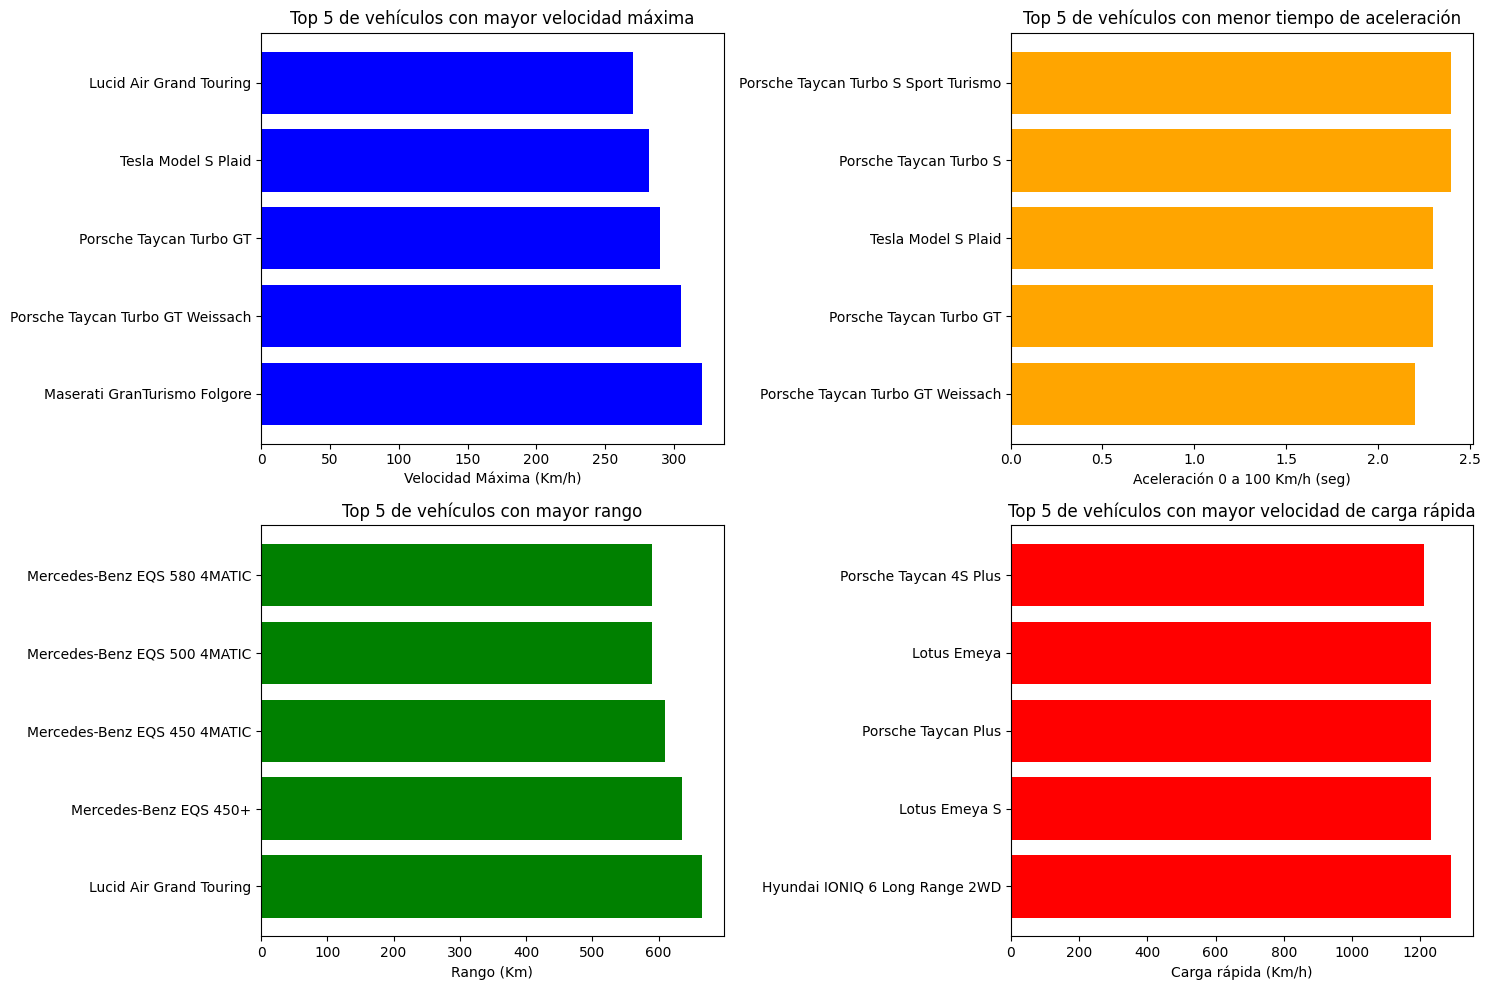

In [73]:
# Obtener los top 5 de cada variable
top_5_speed = df.sort_values(by='Velocidad Máxima (Km/h)', ascending=False).head(5)
top_5_acceleration = df.sort_values(by='Aceleración 0 a 100 Km/h (seg)').head(5)
top_5_range = df.sort_values(by='Rango (Km)', ascending=False).head(5)
top_5_fastcharge = df.sort_values(by='Carga rápida (Km/h)', ascending=False).head(5)

# Crear gráficos de barras para cada variable
plt.figure(figsize=(15, 10))

# Gráfico para la velocidad máxima
plt.subplot(2, 2, 1)
plt.barh(top_5_speed['Nombre del vehículo'], top_5_speed['Velocidad Máxima (Km/h)'], color='blue')
plt.xlabel('Velocidad Máxima (Km/h)')
plt.title('Top 5 de vehículos con mayor velocidad máxima')

# Gráfico para la aceleración
plt.subplot(2, 2, 2)
plt.barh(top_5_acceleration['Nombre del vehículo'], top_5_acceleration['Aceleración 0 a 100 Km/h (seg)'], color='orange')
plt.xlabel('Aceleración 0 a 100 Km/h (seg)')
plt.title('Top 5 de vehículos con menor tiempo de aceleración')

# Gráfico para el rango
plt.subplot(2, 2, 3)
plt.barh(top_5_range['Nombre del vehículo'], top_5_range['Rango (Km)'], color='green')
plt.xlabel('Rango (Km)')
plt.title('Top 5 de vehículos con mayor rango')

# Gráfico para la carga rápida
plt.subplot(2, 2, 4)
plt.barh(top_5_fastcharge['Nombre del vehículo'], top_5_fastcharge['Carga rápida (Km/h)'], color='red')
plt.xlabel('Carga rápida (Km/h)')
plt.title('Top 5 de vehículos con mayor velocidad de carga rápida')

plt.tight_layout()
plt.show()


Vemos que el vh más costoso no es el que mejor característica tiene de todos. Pero si los Porsche son costosos y tienen buenas características. ningún vh económico está dentro de los top de mejor características. Esto requiere un análsis más profundo para encontrar una lista óptima entre eficiencia y precio.